In [28]:
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob

## Synthatic Methods

In [39]:
def runLengthEncoding(list_str):
    # Generate ordered dictionary of all lower
    # case alphabets, its output will be
    # dict = {'w':0, 'a':0, 'd':0, 'e':0, 'x':0}

    count = 1
    previous = ""
    counts = []
    words = []


    for word in list_str:
        if word != previous:
            if previous:
                counts.append(count)
                words.append(previous)
            count = 1
            previous = word
        else:
            count += 1
    else:
        counts.append(count)
        words.append(previous)

    result_join = " ".join(f"{str(count)}{word}" for word, count in zip(words, counts))


    return result_join, words, counts

def Ngrams(strSeq, n=2):
    strSeq_blob = TextBlob(" ".join([word for word in strSeq]))
    seq_grams = strSeq_blob.ngrams(n)
    print(seq_grams)
    grammed_words = ["".join([w for w in sentence]) for sentence in seq_grams]
    print(grammed_words)
    # grammed_strSeq = [strSeq[i] + strSeq[i+1] for i in range(0, len(strSeq)-1)]
    # print(grammed_strSeq)

    return grammed_words

def BagofWords(strSeq):
    for sample in set(strSeq):
        print(sample)
        print(strSeq.count(sample))
    return dict((sample, strSeq.count(sample)) for sample in set(strSeq))

def tf(strDict, unique_set):
    """

    :param strDict: Bag of words dict of the sequence
    :return: tf for each element of the dict
    """

    nk = sum(strDict.values())
    print(strDict)
    strDict_tf = {}

    for word in unique_set:
        if(word in list(strDict.keys())):
            strDict_tf[word] = {"freq":strDict[word], "tf":-np.log(nk/strDict[word]), "idf_cnt":1}

        else:
            strDict_tf[word] = {"freq":0, "tf":0, "idf_cnt":0}

    return strDict_tf

def idf(strings_list):
    n = len(strings_list)
    idf = dict.fromkeys(strings_list[0].keys(), 0)
    for l in strings_list:
        for word, count in l.items():
            if count > 0:
                idf[word] += 1

    for word, v in idf.items():
        idf[word] = np.log(n / float(v))

    return idf

def tf_idf(strDict, unique_set):
    """

    :param strDict: Dict with doc as keys and word list as values {doc1:["a", "a", "b"], doc2:[...}
    :return: tf_idf for each word of each doc, and tf for each word of each doc
    """

    keys = list(strDict.keys())
    n_docs = len(keys)

    idf = dict.fromkeys(unique_set, 0)
    tf_Dict = {doc:{} for doc in keys}
    tf_idf_Dict = {doc:{} for doc in keys}

    for doc_i in keys:

        #bag of words of doc
        BoW = BagofWords(strDict[doc_i])
        #tf of doc
        tf_Dict[doc_i] = tf(BoW, unique_set)

        for word in unique_set:
            if word in list(BoW.keys()):
                idf[word] += 1

    for word, v in idf.items():
        idf[word] = np.log(n_docs / float(v))

        for doc in keys:
            tf_idf_Dict[doc][word] = tf_Dict[doc][word]["tf"]*idf[word]

    return tf_idf_Dict, tf_Dict

def Decode_tfDict(strDict, tf_Dict):
    keys = list(strDict.keys())
    n_docs = len(keys)

    strDecode = {doc_i:[] for doc_i in keys}
    for doc_i in keys:
        print(len(strDict[doc_i]))
        tf = tf_Dict[doc_i]
        strDecode[doc_i] = [tf[word]["tf"] for word in strDict[doc_i]]

    return strDecode



## Stat Methods

In [31]:
def NewWindowStat(inputSignal, statTools, fs, window_len=50, window="hanning"):

	win = eval('np.' + window + '(window_len)')

	if inputSignal.ndim != 1:
		raise ValueError("smooth only accepts 1 dimension arrays.")
	if inputSignal.size < window_len:
		raise ValueError("Input vector needs to be bigger than window size.")
	if window_len < 3:
		return inputSignal

	inputSignal = inputSignal - np.mean(inputSignal)

	WinRange = int(window_len / 2)

	sig = np.r_[inputSignal[WinRange:0:-1], inputSignal, inputSignal[-1:len(inputSignal) - WinRange:-1]]

	if(len(statTools)>1):

		output = np.zeros((len(inputSignal), len(statTools)))

		for i in range(int(WinRange), len(sig) - int(WinRange)):

			for n, statTool in enumerate(statTools):

				signal_segment = sig[i - WinRange:WinRange + i]
				if(statTool is "zcr"):
					output[i - int(WinRange), n] = ZeroCrossingRate(signal_segment)
				elif(statTool is 'Azcr'):
					A = np.max(signal_segment)
					output[i - int(WinRange), n] = A*ZeroCrossingRate(signal_segment)
				elif(statTool is "std"):
					output[i - int(WinRange), n] = np.std(signal_segment*win)
				elif(statTool is "skw"):
					output[i - int(WinRange), n] = skew(signal_segment)
				elif (statTool is "mean"):
					output[i - int(WinRange), n] = np.mean(signal_segment*win)
				elif (statTool is "subPks"):
					pks = [0]
					win_len = window_len
					while (len(pks) < 10):
						pks = detect_peaks(signal_segment, valley=False,
										   mph=np.std(signal_segment))
						if (len(pks) < 10):
							win_len += int(win_len / 5)
					sub_zero = pks[1] - pks[0]
					sub_end = pks[-1] - pks[-2]
					subPks = np.r_[sub_zero, (pks[1:-1] - pks[0:-2]), sub_end]
					output[i - int(WinRange), n] = np.mean(subPks)

				elif (statTool is "findPks"):
					pks = detect_peaks(signal_segment*win, valley=False,
									   mph=np.std(signal_segment))
					LenPks = len(pks)
					output[i - int(WinRange), n] = LenPks

				elif(statTool is 'sum'):
					output[i - WinRange, n] = np.sum(abs(signal_segment)*win)
				elif (statTool is 'normal'):
					output[i - WinRange, n] = normaltest(signal_segment)[0]
				elif (statTool is 'krt'):
					output[i - WinRange, n] = kurtosis(signal_segment)

				elif (statTool is 'AmpDiff'):
					maxPks = detect_peaks(signal_segment*win, valley=False,
										  mph=np.std(signal_segment))
					minPks = detect_peaks(signal_segment*win, valley=True,
										  mph=np.std(signal_segment))
					AmpDiff = np.sum(signal_segment[maxPks]) - np.sum(signal_segment[minPks])
					output[i - WinRange] = AmpDiff

				elif (statTool is "SumPS"):
					f, Pxx = PowerSpectrum(signal_segment*win, fs=fs, nperseg=WinRange / 2)
					sps = SumPowerSpectrum(Pxx)
					output[i - WinRange, n] = sps

				elif (statTool is "AmpMean"):
					output[i - WinRange, n] = np.mean(abs(signal_segment))

				elif (statTool is "Spikes1"):
					ss = 0.1 * max(sig)
					pkd, md = Spikes(signal_segment, mph=ss)
					output[i - WinRange, n] = pkd

				elif (statTool is "Spikes2"):
					ss = 0.1 * max(sig)
					pkd, md = Spikes(signal_segment, mph=ss)
					output[i - WinRange, n] = md

				elif (statTool is "Spikes3"):
					ss = 0.1 * max(sig)
					pkd, md = Spikes(abs(signal_segment), mph=ss)
					output[i - WinRange, n] = md

				# elif (statTool is "df"):


		# output = output - np.mean(output)
		# output = output / max(output)

	else:
		output = WindowStat(inputSignal, statTools[0], fs, window_len=50, window='hanning')

	return output


def ZeroCrossingRate(signal):
	signal = signal - np.mean(signal)
	ZCVector = np.where(np.diff(np.sign(signal)))[0]

	return len(ZCVector)

def findPeakDistance(signal, mph, threshold):
	pks = detect_peaks(signal, mph = mph, show = False)
	vpks = detect_peaks(signal, mph= mph, valley=True)

	if(len(vpks)> len(pks)):
		pks = vpks

	signaldPks = np.zeros(np.size(signal))
	dpks = np.log10(abs(np.diff(pks) - np.mean(np.diff(pks))) + 1)

	for i in range(0, len(dpks)):
		if(i == 0):
			signaldPks[0:pks[i]] = dpks[i]
			signaldPks[pks[i]:pks[i + 1]] = dpks[i]
		elif(i == len(dpks)-1):
			signaldPks[pks[i]:pks[i+1]] = dpks[-1]
		else:
			signaldPks[pks[i]:pks[i+1]] = dpks[i]

def MF_calculus(Pxx):
    sumPxx = np.sum(Pxx)
    mf = 0
    for i in range(0, len(Pxx)):
        if(np.sum(Pxx[0:i]) < sumPxx/2.0):
            continue
        else:
            mf = i
            break

    return mf

def SumPowerSpectrum(Pxx):
    return np.sum(Pxx)

def PowerSpectrum(data, fs, nperseg):
    f, Pxx = sc.periodogram(data, fs=fs)

    return f, Pxx

def Spikes(inputSignal, mph, edge="rising"):
	pks = detect_peaks(inputSignal, mph=mph)
	numPics = len(pks)
	if(len(pks)<2):
		meanDistance=0
	else:
		meanDistance = np.mean(np.diff(pks))

	return numPics, meanDistance

def mean_norm(sig):
    a = sig-np.mean(sig)
    return a/max(a)

def quantilestates(sample, quantile_vals):
	alpha = ["a", "b", "c", "d"]
	sample_quantiles = list(quantile_vals)
	sample_quantiles.append(sample)

	return alpha[list(np.sort(sample_quantiles)).index(sample)]

def quantilstatesArray(signal, quantile_vals, conc=True):
	if(conc):
		return "".join([quantilestates(sample, quantile_vals) for sample in signal])
	else:
		return [quantilestates(sample, quantile_vals) for sample in signal]

def concat_np_strings(mat_string, axis=0):
	"""

	:param mat_string: NxM string matrix which has been generated from a signal
	:param axis:	   concatenate based on the axis selected
	:return: 		   concatenated array
	"""

	return np.apply_along_axis("".join, axis, mat_string)[0]



## Text Plot

In [68]:
from colorutils import Color, ArithmeticModel

color_list = ["dodgerblue", "orangered", "lightgreen", "mediumorchid", "gold", "firebrick", "darkorange", "springgreen", "lightcoral"]
primary_colors = {"d":Color(web="#e3c44c", arithmetic=ArithmeticModel.BLEND), "a":Color(web="#d73824", arithmetic=ArithmeticModel.BLEND), "c":Color(web="#66CB5E", arithmetic=ArithmeticModel.BLEND), "b":Color(web="#6e91ee",arithmetic=ArithmeticModel.BLEND)}

def strsignal2color(signal, str_signal, ax):
    ax.plot(signal)
    for i, char_seq in enumerate(set(str_signal)):
        condition = np.array([char_i == char_seq for char_i in str_signal])
        color_seq = tuple(np.divide(np.sum([primary_colors[char] for char in list(char_seq)]).rgb, 255))
        ax.fill_between(np.linspace(0, len(signal), len(signal)), min(signal), max(signal), where=condition, color=color_seq, alpha=0.3)


## Generate Random Signal

In [50]:
lgth = 50

noise = np.random.normal(0, 1, lgth)

s0 = 10*noise*np.ones(lgth)
s1 = noise*np.ones(lgth)

s = np.r_[s0, s1, s0]

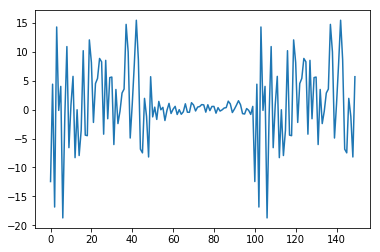

In [52]:
plt.plot(s)

In [64]:
proc_s = NewWindowStat(s, ["std", "mean", "Azcr"], 1, 10)

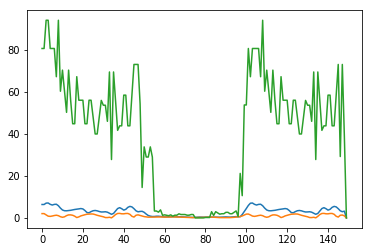

In [65]:
plt.plot(abs(proc_s))

['d', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'c', 'd', 'c', 'b', 'b', 'd', 'c', 'c', 'c', 'b', 'b', 'c', 'c', 'c', 'b', 'b', 'c', 'c', 'c', 'c', 'c', 'd', 'b', 'd', 'c', 'b', 'b', 'b', 'c', 'c', 'b', 'b', 'c', 'd', 'd', 'd', 'c', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'a', 'b', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'a', 'b', 'b', 'c', 'c', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'c', 'd', 'c', 'b', 'b', 'd', 'c', 'c', 'c', 'b', 'b', 'c', 'c', 'c', 'b', 'b', 'c', 'c', 'c', 'c', 'c', 'd', 'b', 'd', 'c', 'b', 'b', 'b', 'c', 'c', 'b', 'b', 'c', 'd', 'b', 'd', 'b', 'a']
['d', 'c', 'd', 'c', 'b', 'd', 'c', 'b', 'c', 'b', 'c', 'd', 'b', 'd', 'c', 'b', 'c', 'b', 'c', 'd', 'c', 'b', 'a', 'b', 'a', 'b', 'a', 'b', 'c', 'd', 'c', 'd', 'c', 'b', 'd', 'c', 'b', 'c', 'b', 'c', 'd', 'b', 'd', 'c', 'b', 'c', 'b', 'c', 'd', 'b'

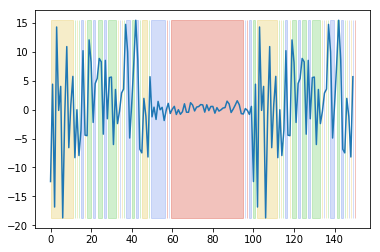

In [76]:
quantile_vals = np.quantile(proc_s[:, 2], [0.25, 0.5, 0.75])
str_feat = quantilstatesArray(proc_s[:,2], quantile_vals, conc=False)
ax = plt.subplot(1,1,1)

strsignal2color(s, str_feat, ax)
print(str_feat)
rl_str, rl_str_feat, rl_counts = runLengthEncoding(str_feat)
print(rl_str_feat)
ngrams_str_feat= Ngrams(rl_str_feat, n=2)

print(set(ngrams_str_feat))

tf_idfDict, tfDict = tf_idf({"0":ngrams_str_feat}, set(ngrams_str_feat))

# proc_str = []

# all_feat_str = []
# docs = {}
# docs_time = {}
# for nbr, feat in enumerate(proc_s.T):
#     quantile_vals = np.quantile(feat, [0.25, 0.5, 0.75])
#     str_feat = quantilstatesArray(feat, quantile_vals, conc=False)
    
#     rl_str, rl_str_feat, rl_counts = runLengthEncoding(str_feat)
    
#     ngrams_str_feat= Ngrams(rl_str_feat, n=5)
    
#     docs[nbr] = ngrams_str_feat
    
#     docs_time[nbr] = rl_counts[:-4]
#     all_feat_str += ngrams_str_feat
    
# sets = set(all_feat_str)
# tf_idfDict, tfDict = tf_idf(docs, sets)

# tf_Seq = Decode_tfDict(docs, tfDict)



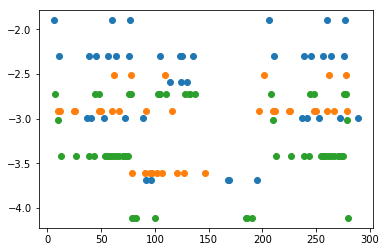

In [47]:
plt.plot(np.cumsum(docs_time[0]), tf_Seq[0], 'o')
plt.plot(np.cumsum(docs_time[1]), tf_Seq[1], 'o')
plt.plot(np.cumsum(docs_time[2]), tf_Seq[2], 'o')